# Modelado: SVM


### Carga de librerías

In [1]:
import pandas as pd
import numpy as np
# Import mlflow for models tracking
import mlflow
# Libraries for models and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

# Visualization libraries
import matplotlib.pyplot as plt


### Carga de ficheros

In [2]:
df = pd.read_csv("../../data/final/df_train_final.csv")
df.head(5)

,TARGET,DAYS_BIRTH,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,QTY_ACTIVE_BUREAU,QTY_APP_LAST_YEAR,RATIO_NONAPPROVED
0,1,-9461,0.139376,0.083037,0.262949,2.0,1.0,0.0
1,0,-16765,0.507626,0.311267,0.622246,1.0,0.0,0.0
2,0,-13778,0.492060,0.774761,0.724000,4.0,1.0,0.0
3,0,-10197,0.363945,0.319760,0.651862,2.0,0.0,0.0
4,0,-13439,0.176653,0.464831,0.715042,4.0,4.0,0.0


### Dataset final

#### Preparación datasets train and test

In [3]:
# Separate TARGET variable from dependent variables
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Divide dataset in train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Generate expermient tracking in MLflow
exp_name = 'Model SVM'
exp_id = mlflow.create_experiment(name=exp_name)

#### Prueba Nro. 1

In [4]:
# Track each run
with mlflow.start_run(experiment_id=exp_id, run_name="SVM - linear"):
    # Create and train SVM model with probability to calculate AUC and class weight
    model = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
    trained_model = model.fit(X_train_scaled, y_train)

    # Evaluate predictions in test dataset of positive class to calculate AUC
    y_pred_auc = trained_model.predict_proba(X_test_scaled)[:, 1]
    # Evaluate model for accuracy metric
    y_pred = trained_model.predict(X_test_scaled)

    # Classes distribution
    class_distribution = np.bincount(y_pred, minlength=len(np.unique(y)))
    class_distribution_percentage = (class_distribution / len(y_pred)) * 100

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_auc)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)


    # Track kernel used for the model
    mlflow.log_param('kernel', 'linear')
    mlflow.log_param('probability', 'True')
    mlflow.log_param('class_weight', 'balanced')

    # Track metrics
    mlflow.log_metric('roc_auc_score', auc_score)
    mlflow.log_metric('accuracy_score', accuracy)
    mlflow.log_metric('precision_score', precision)
    mlflow.log_metric('recall_score', recall)
    mlflow.log_metric('f1_score', f1)

    # Save model
    mlflow.sklearn.log_model(trained_model, "SVM - linear")

    # Close MLflow tracking
    mlflow.end_run()

# Print results
print("Distribución final de clases (conteo):", class_distribution)
print("Distribución final de clases (porcentaje):", class_distribution_percentage)

print(f"AUC: {auc_score:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

2024/11/25 20:24:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Distribución final de clases (conteo): [39747 19458]
Distribución final de clases (porcentaje): [67.13453256 32.86546744]
AUC: 0.7265
Accuracy: 69.15%
Precision: 0.1432
Recall: 0.6366
F1-Score: 0.2338
Confusion Matrix:
[[38156 16671]
 [ 1591  2787]]


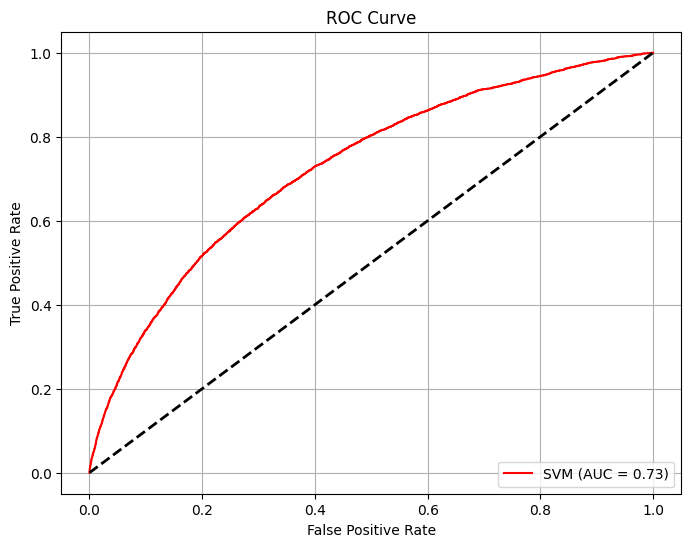

In [5]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_auc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc_score:.2f})", color='red')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Prueba Nro. 2

Ajuste de hiperparámetros con GridSearchCV

In [ ]:
svc = SVC(probability=True)

# Different parameters
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  
    'C': [0.1, 1, 10, 100],                         
    'gamma': ['scale', 'auto'],                   
    'degree': [2, 3, 4]                             
}

# Create GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')
# Train model
grid_search.fit(X_train_scaled, y_train)

# Find best model
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Best model results
print(f"Best Kernel: {best_model.kernel}")
print(f"Best parameters: {grid_search.best_params_}") 
print(f"Best AUC: {grid_search.best_score_:.4f}")

# Evaluate best model
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC in test dataset: {auc_score:.4f}")

Tiempo de ejecución demasiado elevado. El código estuvo días (aprox 1 semana) ejecutándose sin llegar a finalizar.